# <center> Walmart Sales Forecast using LSTM </center>

## Loading the Dataset

In [2]:
# Load necessary dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from matplotlib import rcParams
import datetime
import tensorflow as tf
from util import plotLoss, eval_model
import random

# figure size in inches
rcParams['figure.figsize'] = 13,8
plt.rcParams['font.size'] = '12'

In [54]:
# Reading our dataset into a pandas dataframe
# pandas read csv and parse date in year month day format;

features = pd.read_csv('features.csv', parse_dates = ['Date'], date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv', parse_dates = ['Date'], date_parser=lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').date())
train = pd.read_csv('train.csv', parse_dates = ['Date'], date_parser=lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').date())

In [55]:
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

C:\Users\Waleed's PC\AppData\Local\Temp\ipykernel_13876\2308055250.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['WeekOfYear'] = train.Date.dt.weekofyear


In [56]:
df= train.merge(stores, how="left").merge(features,how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Year          421570 non-null  int64         
 6   Month         421570 non-null  int64         
 7   Day           421570 non-null  int64         
 8   WeekOfYear    421570 non-null  int64         
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
 11  Temperature   421570 non-null  float64       
 12  Fuel_Price    421570 non-null  float64       
 13  MarkDown1     150681 non-null  float64       
 14  MarkDown2     111248 non-null  float64       
 15  MarkDown3     137

In [57]:
df = df.set_index("Date")
df

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,2010,2,5,5,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,1,46039.49,True,2010,2,12,6,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,1,41595.55,False,2010,2,19,7,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,1,19403.54,False,2010,2,26,8,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,1,21827.90,False,2010,3,5,9,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,45,98,508.37,False,2012,9,28,39,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
2012-10-05,45,98,628.10,False,2012,10,5,40,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
2012-10-12,45,98,1061.02,False,2012,10,12,41,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667


In [59]:
df = df.fillna(0)

## Exploratory Data Analysis

## Correlation of Sales with Numerical Variables

We can use maths formula to calculate the relationship between sales and numerical variales

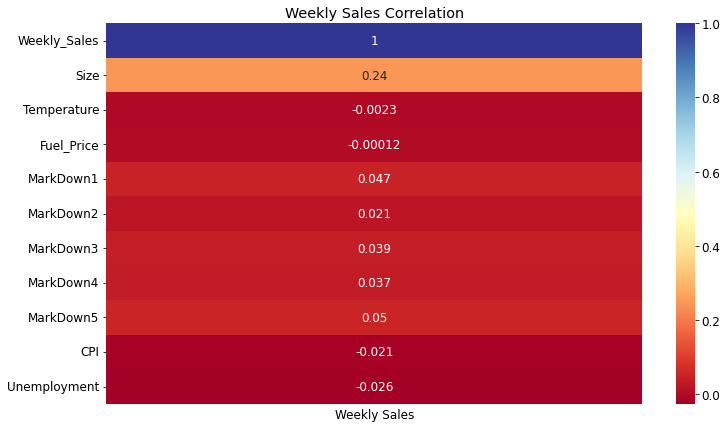

In [60]:
df2 = df.drop(['Dept','Store','Day', "Year" ,'Month', "WeekOfYear", "IsHoliday" ], axis = 1)
plt.figure(figsize = (12, 7))
var = df2.corrwith(df2.Weekly_Sales)
sns.heatmap(var.to_frame(), annot = True, cmap = "RdYlBu")
plt.title("Weekly Sales Correlation")
plt.xticks([])
plt.xlabel("Weekly Sales")
plt.show()

We can see that Weekly sales is most strongly related to the size of the store. It is also weekly corelatd to Markdowns 1-5 and sales are inversely related to CPI and unemployment.

## Correlation between Categotical Features and Weekly Sales
We have looked at the correlation between Sales and other numerical features using mathamatical formula. Now let us look at the relationship of Categircal features with Sales using plots.

### 1) Type of Store
Let us take a look at how many unique types of stores we have


In [61]:
unique_stores = df.Type.unique()
print(df.Type.unique())
print(f'So there are {len(unique_stores)} unique stores in the dataset.')

['A' 'B' 'C']
So there are 3 unique stores in the dataset.


Next we will plot the weekly sales for each store type.

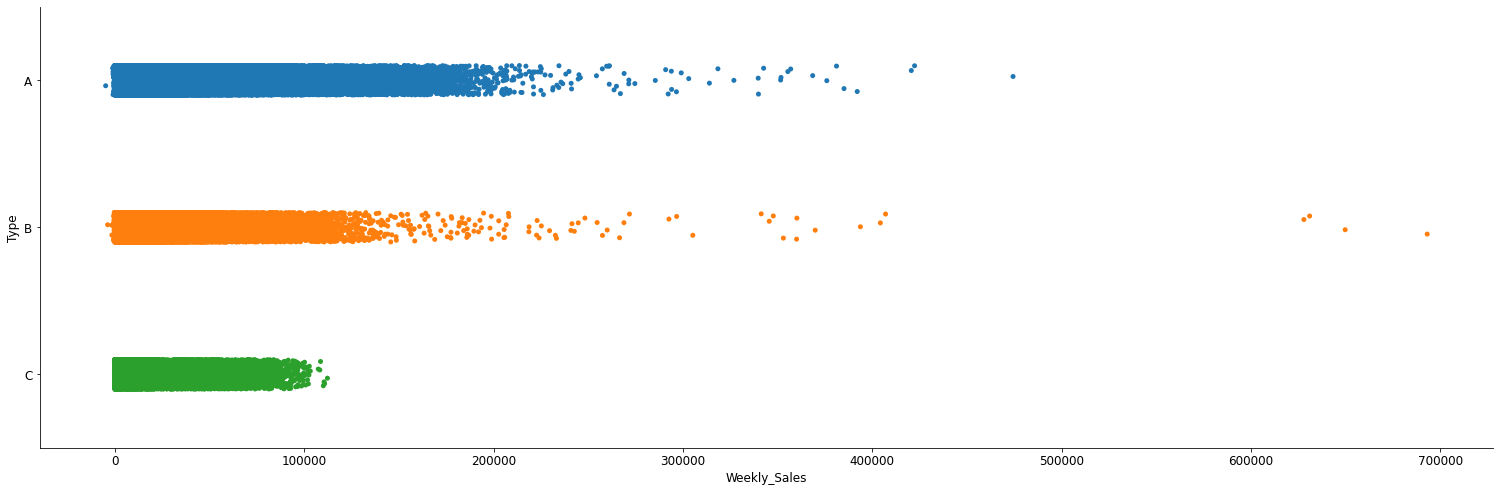

In [62]:
sns.catplot(x = 'Weekly_Sales', y = 'Type', data = df ,height = 7 , aspect = 3)
plt.show()

In [87]:
df.query("Type == 'B' and Weekly_Sales > 600000")

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Dept_code
Date,,,,,,,,,,,,,,,,,,,,
2010-11-26,10,72,693099.36,True,2010,11,26,47,B,126512,55.33,3.162,0.00,0.0,0.00,0.00,0.00,126.669267,9.003,10-72
2011-11-25,10,72,630999.19,True,2011,11,25,47,B,126512,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,10-72
2010-11-26,35,72,627962.93,True,2010,11,26,47,B,103681,46.67,3.039,0.00,0.0,0.00,0.00,0.00,136.689571,8.763,35-72
2011-11-25,35,72,649770.18,True,2011,11,25,47,B,103681,47.88,3.492,1333.24,0.0,58563.24,20.97,6386.86,140.421786,8.745,35-72


So we can see that stores of type A and B have made more sales as compared to stores of type C . So the variable is "TYPE" is carrying some information the Amount of sales

## 2) Store Number
Let us look at how many stores we have and visualize the performance of the different stores.

In [63]:
unique_stores = df.Store.unique()
print(f'So we have {len(unique_stores)} unique stores in the dataset. Namely; \n {unique_stores}')

So we have 45 unique stores in the dataset. Namely; 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


Next we will look at the averge sales in these stores to check how Stores affect sales

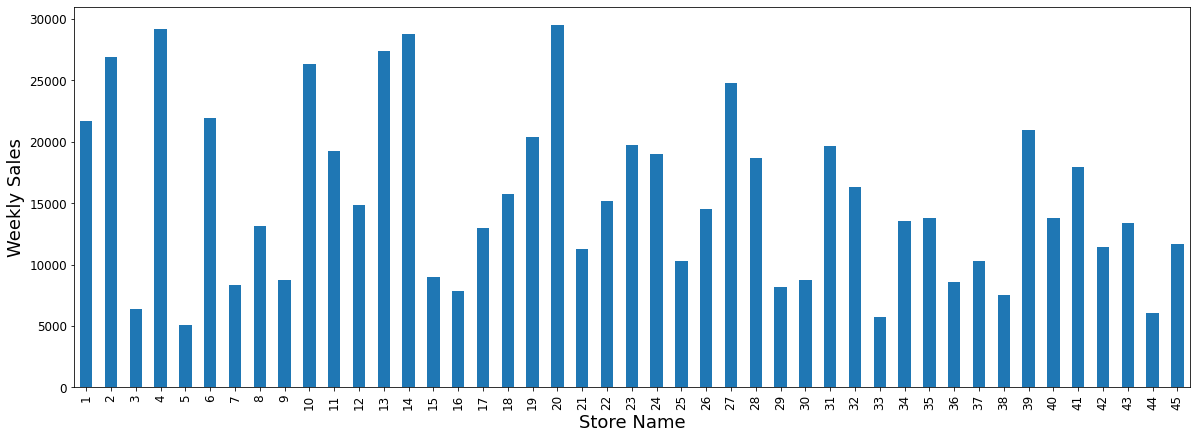

In [64]:
plt.figure(figsize= (20,7))
df.groupby(['Store']).mean().Weekly_Sales.plot(kind = 'bar')
plt.ylabel("Weekly Sales", fontsize = 18)
plt.xlabel("Store Name", fontsize = 18)
plt.show()

### 3) Department Number
Each store has many departments in it. Next we will look at the average sales of each department across all stores.

In [65]:
unique_depts = df.Dept.unique()
print(f'So we have {len(unique_depts)} unique Departments in the dataset. Namely; \n {unique_depts}')

So we have 81 unique Departments in the dataset. Namely; 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]


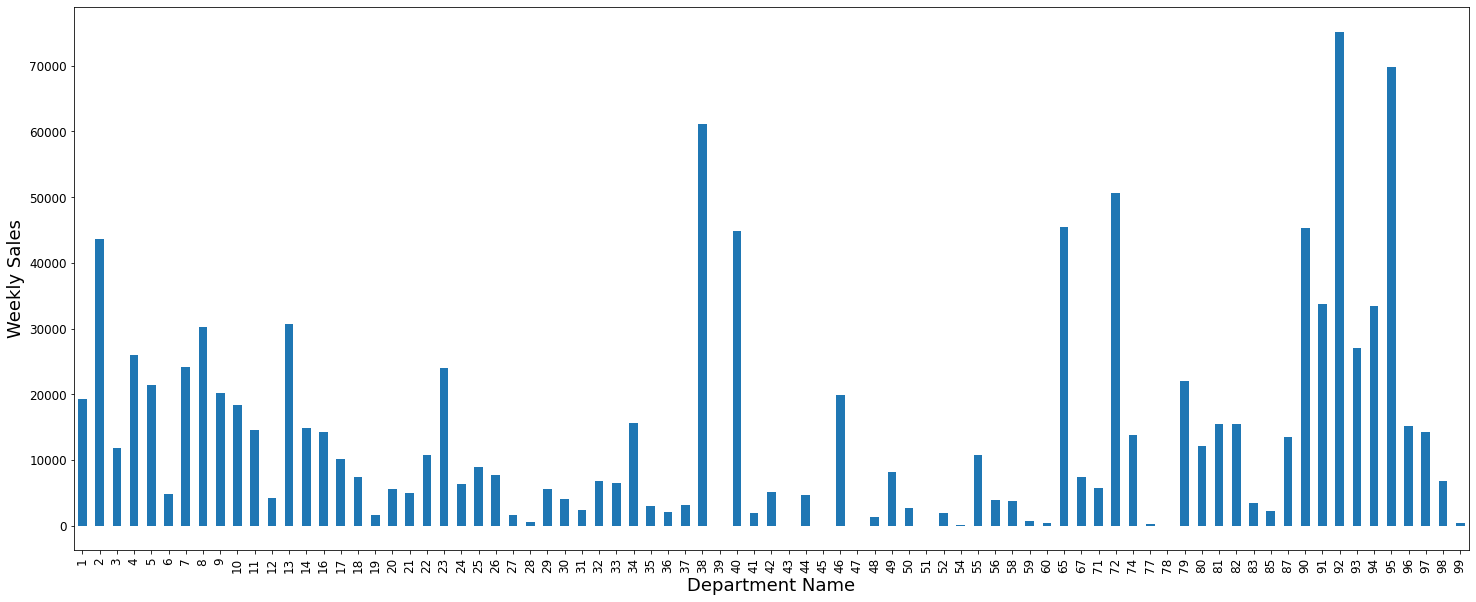

In [66]:
plt.figure(figsize= (25,10))
df.groupby(['Dept']).mean().Weekly_Sales.plot(kind = 'bar')
plt.ylabel("Weekly Sales", fontsize = 18)
plt.xlabel("Department Name", fontsize = 18)

plt.show()

Here some departments numbers are missing like 84. It is either sich a department number does not exist or more probably we do not have data corresponding to that department

### 4) Holidays
We also have information if during some particular week there were any holidays like Christman or Thanksgiving. Let us check if that can affect the sales or not.

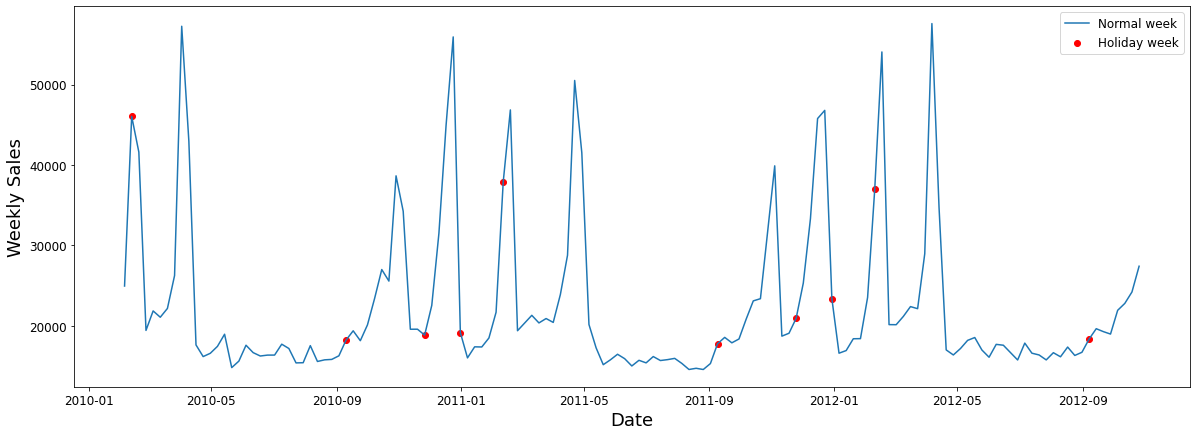

In [67]:
plt.figure(figsize = (20, 7))

sample = df.query("Store == 1  & Dept == 1")
data = sample.query('IsHoliday == True')
plt.plot(sample.index , sample.Weekly_Sales, label = "Normal week")
plt.scatter(data.index , data.Weekly_Sales, label = "Holiday week", color = "red")
plt.ylabel("Weekly Sales", fontsize = 18)
plt.xlabel("Date", fontsize = 18)
plt.legend(loc = "upper right")
plt.show()

So from this plot we can see that we have seasonality in our dataset and it is affected by whether there was a holiday or not.

---

Next up we will look at the time series components of our dataset.

## Components of Time Series
### Seasonal Decompose
Ttime series decomposition is a process of deconstructing a time series into the following components:
<pre>
- Trend    —> general movement over time
- Seasonal —> behaviors captured in individual seasonal periods
- Residual —> everything not captured by trend and seasonal components
</pre>

### Types of Decomposition
- Additive
- Multiplicative

#### 1) Additive models
The additive model assumes that all four components of the time series act independent of each other.

=> yt = Tt + St + Rt
<br>
where 
- T: Trend
- S: Seasonality
- R: Residual

Additive trend means when the trend is increasing linearly and additive Seasonality means when the magnitude of the seasonal peaks of the time series remains same across the years.

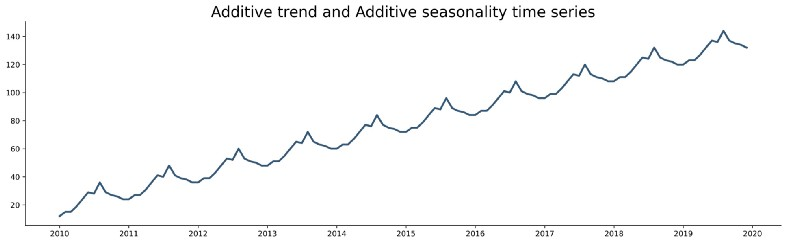

#### Multiplicative models
The multiplicative model assumes that the various components in a time series operate proportionately to each other. According to this model

yt = Tt × St × Rt

Multiplicative trend means when the trends increases in a non-linear (curved) fashion and multiplicative seasonality means when the magnitude of the seasonal peaks is changing with the years

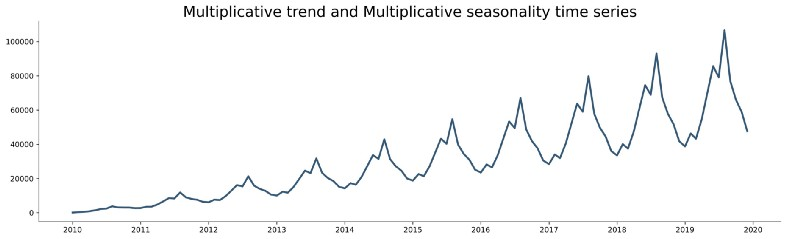

### Types of Time Series
#### 1) Stationary Time Series
It is a time series that does not have predictable patterns in the long term. In other words a time series that does not have trend and seasonality is a stationary time series

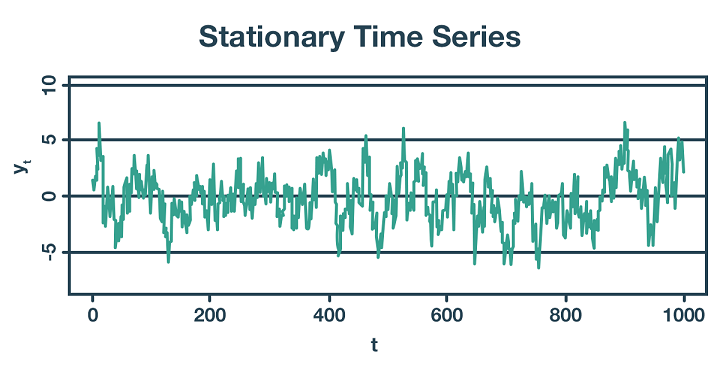

#### 2) Non Stationary Time series
A time series that has trends and seasonality is called non stationary. It is a time series where we see some preditable patterns in it

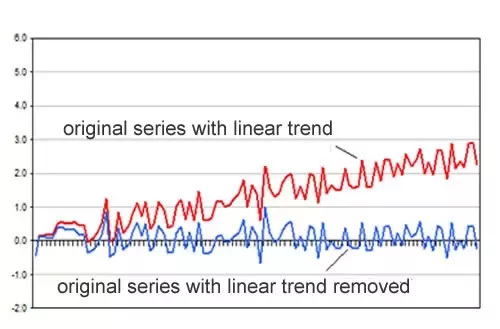

## Components of Time Series:
### 1) Trends:
- The trend shows the general tendency of the data to increase or decrease during a long period of time.
- Trend must be upward, downward, or stable.

<center><img src=https://static.packt-cdn.com/products/9781788292740/graphics/42912ccd-229d-4863-99ba-54e5346aa4d7.png width="500"></center>

#### i) Linear Trend 
If the set of data cluster more or less around a straight line


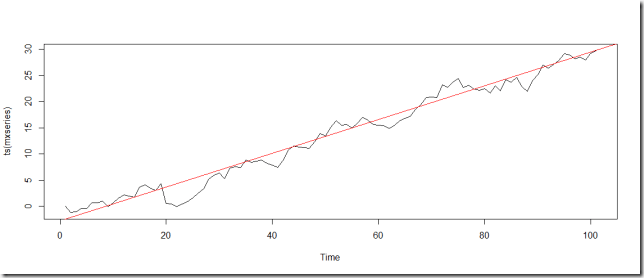

#### ii) Non Linear Trend
If instead of a straight line the trend follows a curved path then we have a no linear trend

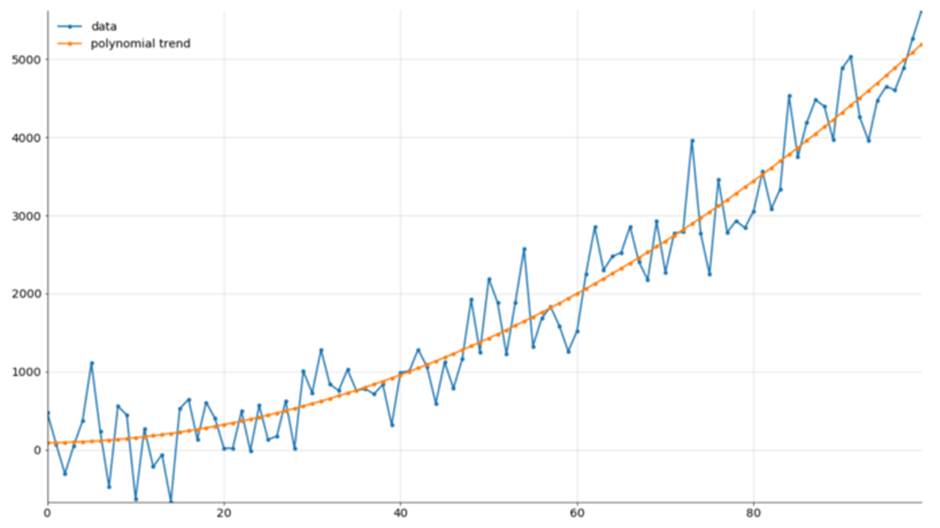

In [68]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

def checkTrend(store, dept):

	sample = df.query("Store ==  @store and Dept ==  @dept")

	x_line = np.arange(1, len(sample) + 1, 1)

	popt, _ = curve_fit(objective, x_line, sample.Weekly_Sales)
	a, b, c = popt
	# calculate the output for the range
	y_line = objective(x_line, a, b, c)
	# create a line plot for the mapping function
	decompose = seasonal_decompose(sample['Weekly_Sales'])

	plt.figure(figsize=(20, 8))

	plt.subplot(1,2,1)
	plt.plot( sample.index , decompose.observed)
	plt.plot(sample.index , y_line, '--', color='red')
	plt.ylabel("Weekly Sales")
	plt.xlabel("Time")
	plt.xticks(rotation=45)


	plt.subplot(1,2,2)
	plt.plot( sample.index , decompose.trend)
	plt.ylabel("Weekly Sales")
	plt.xlabel("Time")
	plt.xticks(rotation=45)


	plt.show()

#### 1) Upward Trend

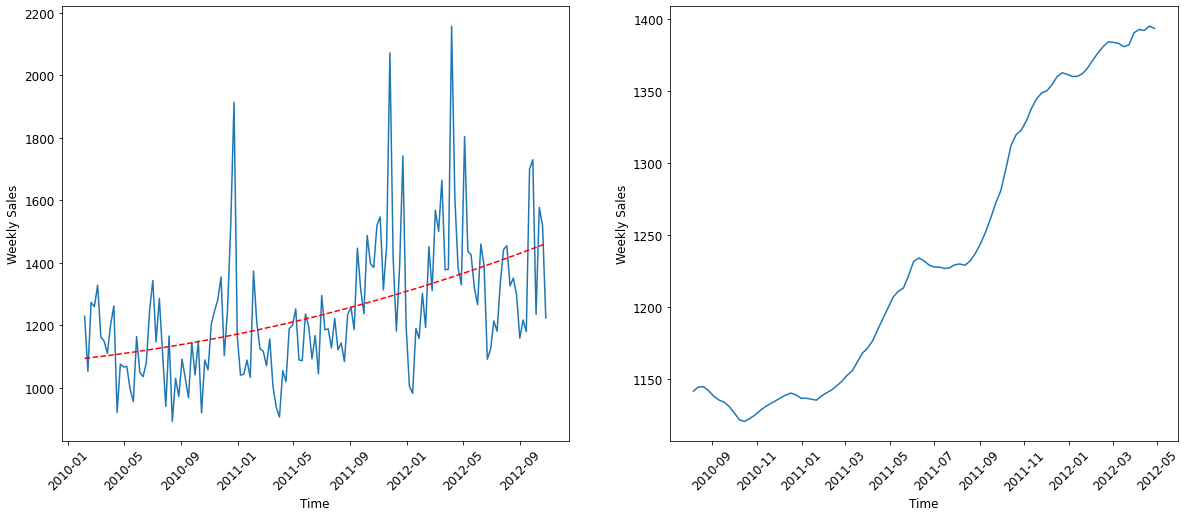

In [69]:
checkTrend(3,21)

#### 2) Downward Trend

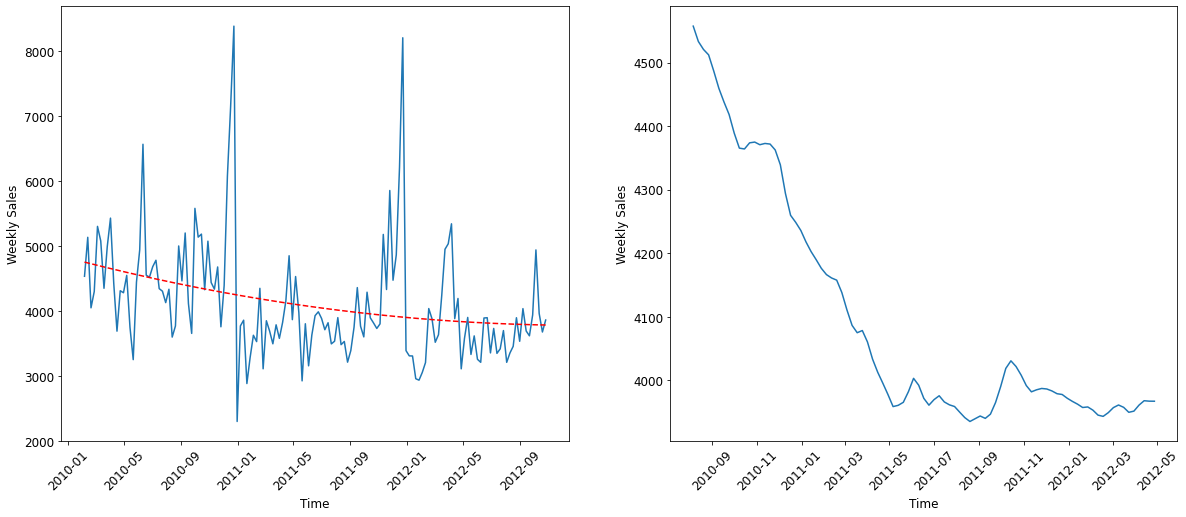

In [70]:
checkTrend(17, 21)

#### 3) Stable trend

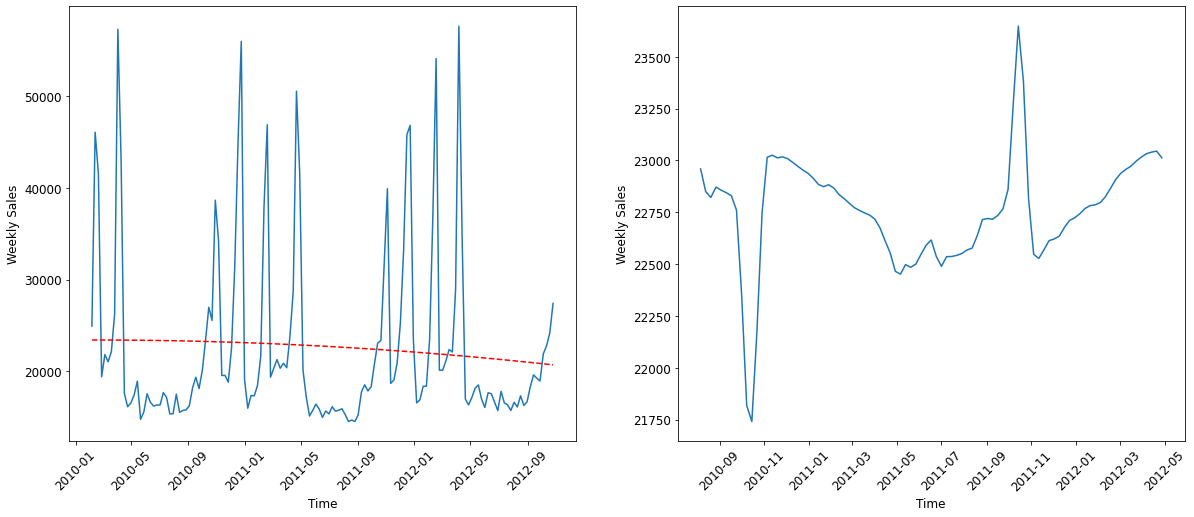

In [71]:
checkTrend(1,1)

### 2) Seasonality

Seasonality is periodic in nature having a span of almost a year. The dataset has seasonality if we see the same peaks after a period of 12 months.
While in trends we check the avergae values at a given moment in time if they are moving upwards, downwards or stable

---


Seasonality is due to the repetition of similar conditions at the same time of the following year. These conditions may be natural or man made. These may include climate changes and holidays like christmas.

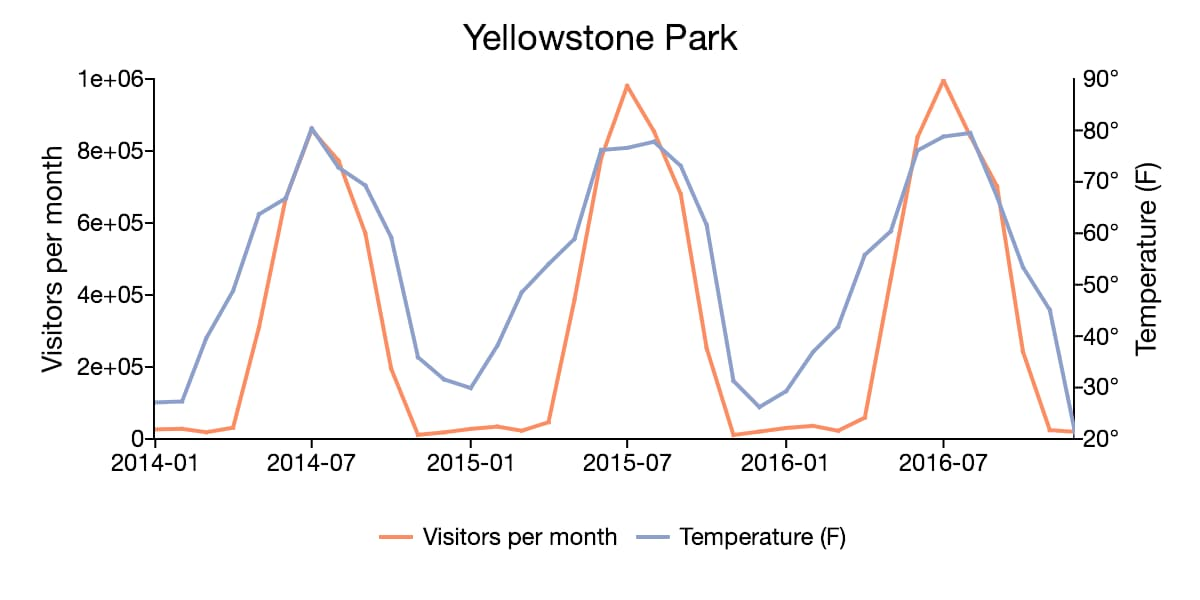

#### Period of Time Series

Period of a time series is the number of timestamps after which the seasonal nature of the time series is repeated. For example, if the time series is monthly and the period is 12, then the seasonal nature of the time series is repeated after 12 months.

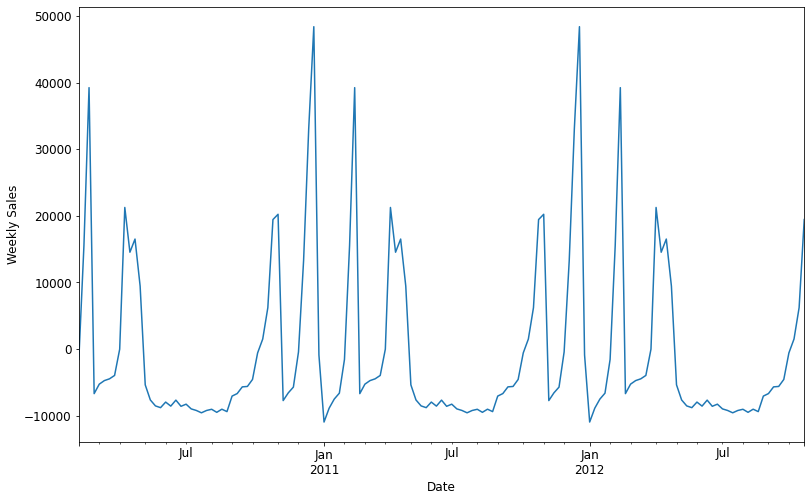

In [72]:
sample = df.query("Dept ==  1 and Store == 2")
decompose = seasonal_decompose(sample['Weekly_Sales'],model='additive')
decompose.seasonal.plot()
plt.ylabel("Weekly Sales")
plt.show()

### Cyclic Variations
The variations in a time series that have a period of more than a year. These variations are due to the affect of the ecomonic forces.

---

A time series is seasonal if the pattern repeats after a fixed period lets suppose after a year. The series will becomes cyclic if the pattern is repeated after unequal periods. Lets say we see a peak after every 60 - 70 weeks but its not after a fixed period. Then the series will be cyclic. This fluctutations in the period for the peaks are due to the state of the economy which are constantly changing

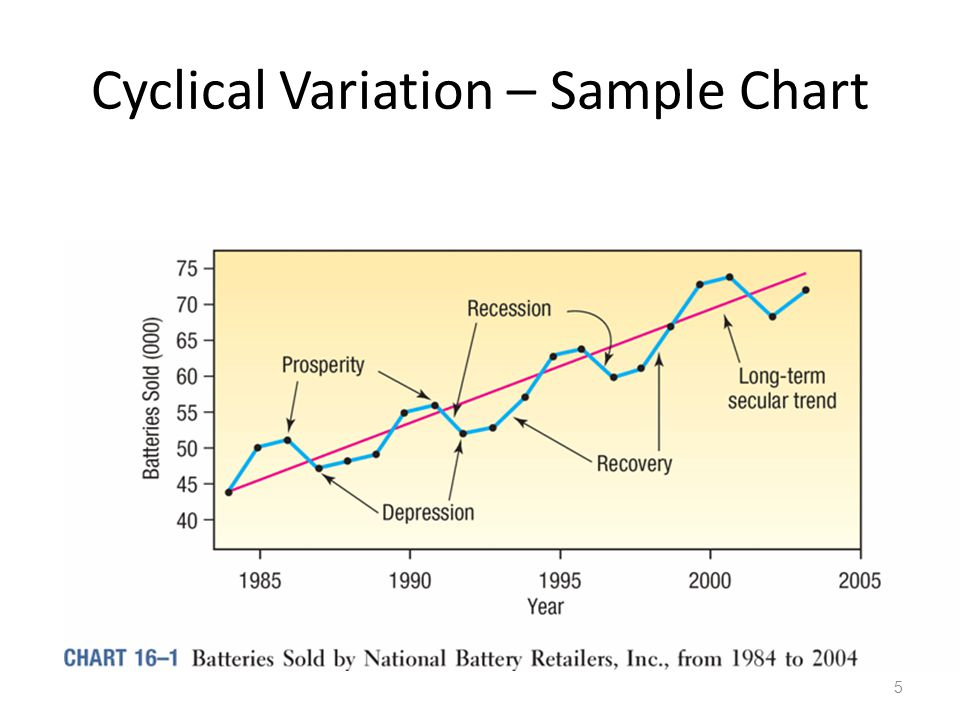

### Random Movements
These are the movements in the time series that are unforeseen and can not be predicted. These include earthquakes, famines or wars etc which might affect the variable under study
<br>
It is basically what is left over once trends and seasonality have been removed from the data (randomness of data)

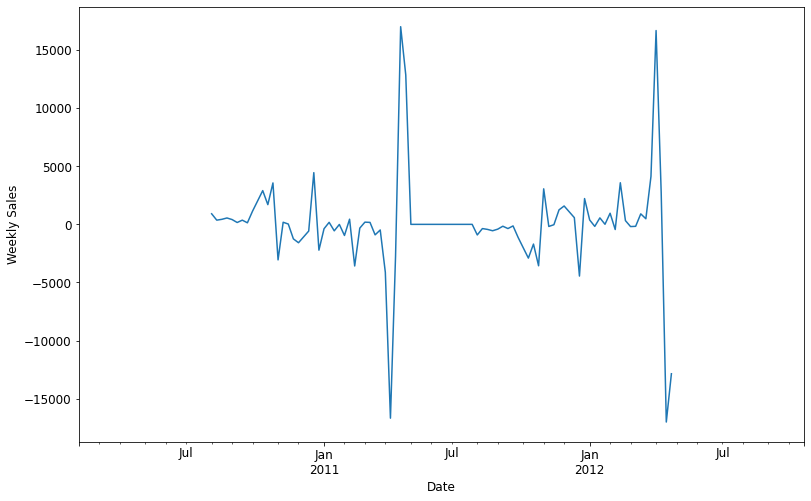

In [73]:
sample = df.query("Dept ==  1 and Store == 1")
decompose = seasonal_decompose(sample['Weekly_Sales'],model='additive', period = 52)
decompose.resid.plot()
plt.ylabel("Weekly Sales")
plt.show()

---

Now that we are done with the analysis of the data. We will now check if the data has any missing values and if so we will fill them.

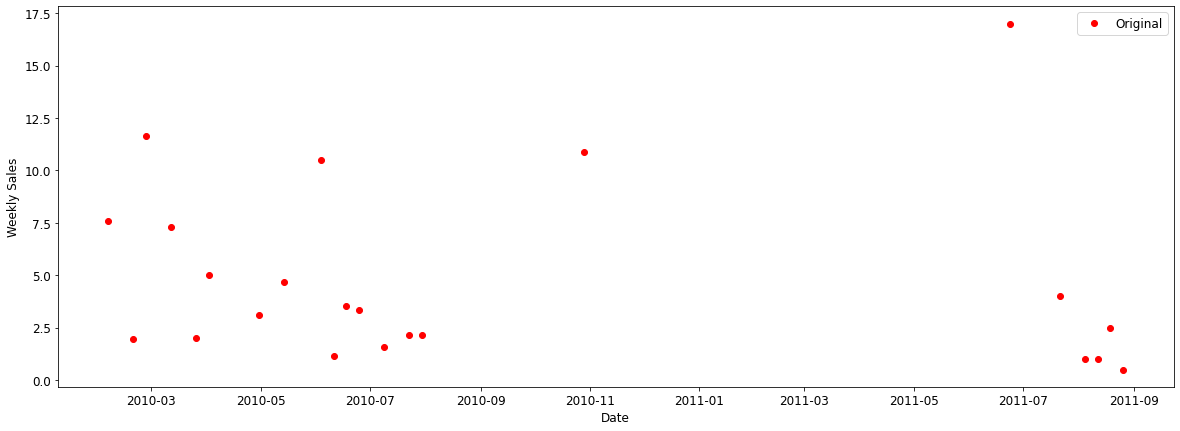

In [92]:
plt.figure(figsize = (20, 7))

sample = df.query('Store == 45 & Dept == 51') 

plt.plot(sample.index, sample.Weekly_Sales, "ro")

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(["Original", "Backward Fill", "Forward Fill"], loc = 'best')
plt.show()

### Filling up missing data
We can fill up missing data using interpolation

### Interpolation
#### 1) Bfill / Ffill
We can use the last value to approximate next value <br>
We can also use the next value to approximate previous value


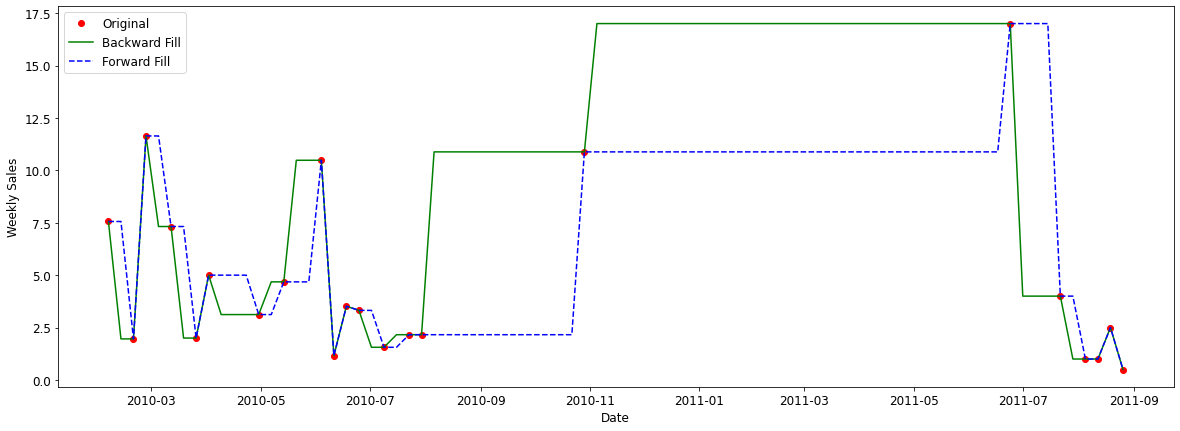

In [22]:
plt.figure(figsize = (20, 7))

sample = df.query('Store == 45 & Dept == 51') 

sample_copy = sample.resample('1W-FRI').bfill()
sample_copy2 = sample.resample('1W-FRI').ffill()

plt.plot(sample.index, sample.Weekly_Sales, "ro")
plt.plot(sample_copy.index, sample_copy.Weekly_Sales, "g-")
plt.plot(sample_copy2.index, sample_copy2.Weekly_Sales, "b--")

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(["Original", "Backward Fill", "Forward Fill"], loc = 'best')
plt.show()

#### ii) Linear interpolation
This type of interpolation works by joining a straight line between the non-missing points and using the slope of the line to estimate missing points. <br>
<br>
**NOTE** 
We draw a different line between every 2 consecutive non-missing points

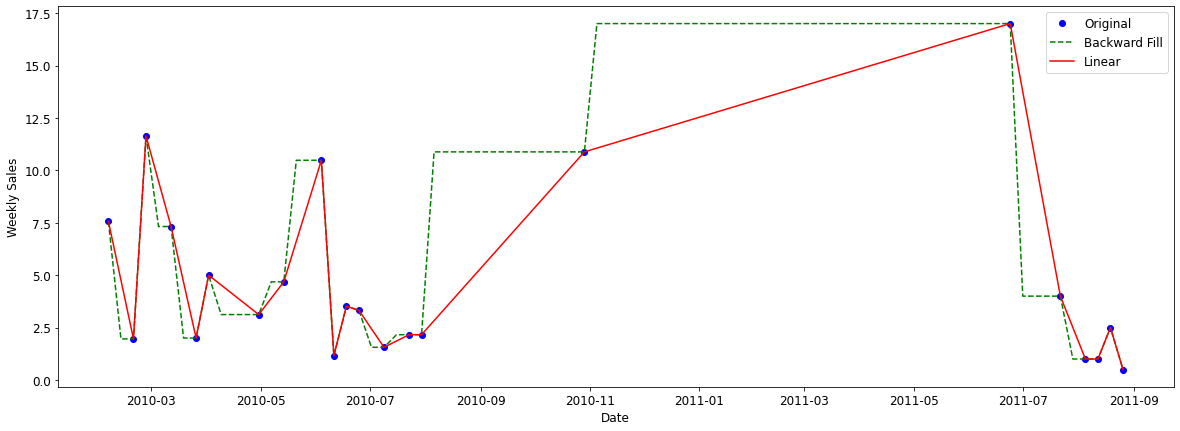

In [23]:
plt.figure(figsize = (20, 7))

sample = df.query('Store == 45 & Dept == 51')


sample2 = sample.resample('1W-FRI').interpolate(method='linear')

plt.plot(sample.index, sample.Weekly_Sales, "bo")
plt.plot(sample_copy.index, sample_copy.Weekly_Sales, "g--")
plt.plot(sample2.index, sample2.Weekly_Sales, "r-")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(["Original","Backward Fill", "Linear"], loc = 'best')
plt.show()

### iii) Cubic Interpolation 
Instead of fitting a straight line between 2 non-missing points cubic interpolation works by fitting a 3rd degree polynomial.

---

While cubic interpolation can give good results by introducing a curved pattern in data it can sometimes overshoot and give poorly estimated values.
When the curve changes direction, cubic splines tend to produce local extrema that lie in between breakpoints instead of on the breakpoints. In other words, they "overshoot" the breakpoint targets. This may be physically unrealistic in some applications.

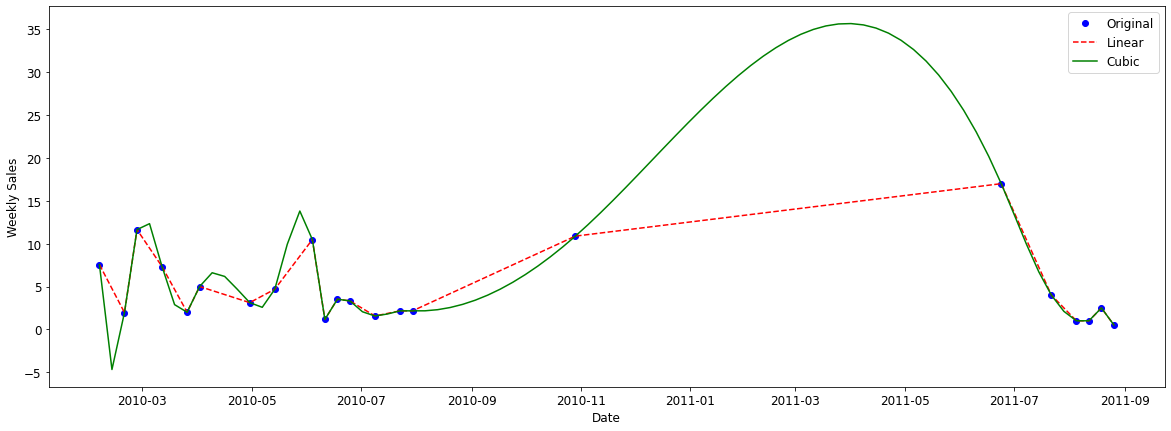

In [24]:
plt.figure(figsize = (20, 7))

sample = df.query('Store == 45 & Dept == 51')

sample2 = sample.resample('1W-FRI').interpolate(method='linear')
sample3 = sample.resample('1W-FRI').interpolate(method='cubic')

plt.plot(sample.index, sample.Weekly_Sales, "bo")
plt.plot(sample2.index, sample2.Weekly_Sales, "r--")
plt.plot(sample3.index, sample3.Weekly_Sales, "g-")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(["Original", "Linear", "Cubic"], loc = 'best')
plt.show()

### Best method
The best method of interpolation would be a compromise between linear and cubic. <br> <br>
Monotonic cubic splines avoid this problem. Polynomial segments are monotonic which guarantees that all extrema will occur on the breakpoints.


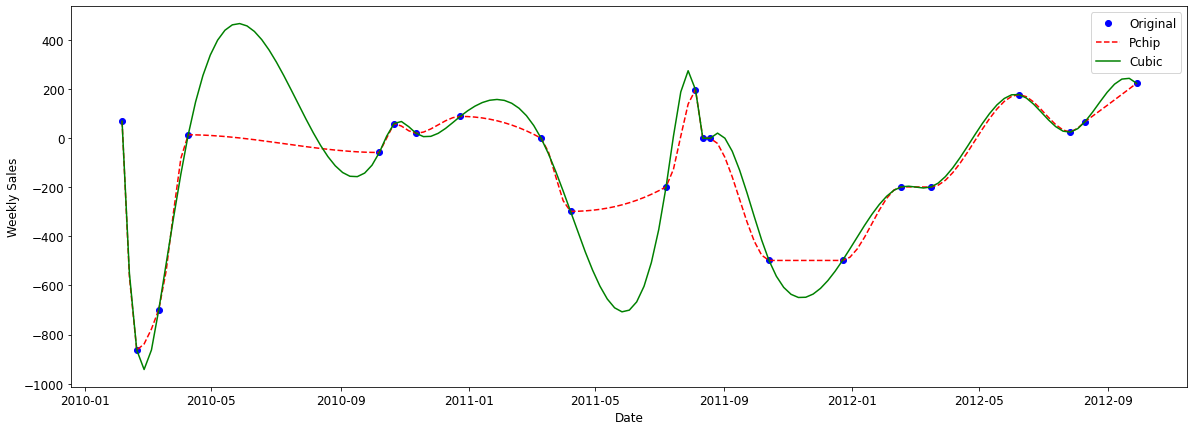

In [25]:
plt.figure(figsize = (20, 7))

sample = df.query('Store == 1 & Dept == 47')
sample2 = sample.resample('1W-FRI').interpolate(method='pchip')
sample3 = sample.resample('1W-FRI').interpolate(method='cubic')

plt.plot(sample.index, sample.Weekly_Sales, "bo")
plt.plot(sample2.index, sample2.Weekly_Sales, "r--")
plt.plot(sample3.index, sample3.Weekly_Sales, "g-")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(["Original", "Pchip", "Cubic"], loc = 'best')


plt.show()

## Negative values
Before we move on to interpolating the data we need to make sure that there are no negative values in the data. <br>

In [75]:
# check negative values of weekly sales in df 
df[df.Weekly_Sales < 0]

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,WeekOfYear,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,
2012-08-10,1,6,-139.65,False,2012,8,10,32,A,151315,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908
2012-05-04,1,18,-1.27,False,2012,5,4,18,A,151315,75.55,3.749,21290.13,0.0,69.89,4977.35,3261.04,221.671800,7.143
2010-02-19,1,47,-863.00,False,2010,2,19,7,A,151315,39.93,2.514,0.00,0.0,0.00,0.00,0.00,211.289143,8.106
2010-03-12,1,47,-698.00,False,2010,3,12,10,A,151315,57.79,2.667,0.00,0.0,0.00,0.00,0.00,211.380643,8.106
2010-10-08,1,47,-58.00,False,2010,10,8,40,A,151315,63.93,2.633,0.00,0.0,0.00,0.00,0.00,211.746754,7.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-12,45,80,-0.43,True,2010,2,12,6,B,118221,27.73,2.773,0.00,0.0,0.00,0.00,0.00,181.982317,8.992
2010-02-19,45,80,-0.27,False,2010,2,19,7,B,118221,31.27,2.745,0.00,0.0,0.00,0.00,0.00,182.034782,8.992
2010-04-16,45,80,-1.61,False,2010,4,16,15,B,118221,54.28,2.899,0.00,0.0,0.00,0.00,0.00,181.692477,8.899


So we have 1285 rows with negative values of weekly sales. We will set them to NaN so they are also interpolated

In [76]:
df.Weekly_Sales= df['Weekly_Sales'].apply(lambda x: np.nan if x < 0 else x)

We have a time series for each department of each store. So we need a unique id for every time series. We can do this by combining the Stores and Departments columns.

In [77]:
df['Store_Dept_code'] = df.apply(lambda x: str(x['Store']) + '-' + str(x['Dept']), axis = 1)
dept_stores = df.Store_Dept_code.unique()
dept_stores

array(['1-1', '1-2', '1-3', ..., '45-96', '45-97', '45-98'], dtype=object)

So we have the folliwing ids for every time series.

In [78]:
print(f'We have a total of {len(dept_stores)} unique combinations of Store and Department')

We have a total of 3331 unique combinations of Store and Department


---

Now we will interpolate the data using "PCHIP"

In [79]:
# First we copy the columns into a temp variable
df_copy = df.head(0)

for val in dept_stores:
    temp = df.query('Store_Dept_code == @val')
    if(len(temp) < 20):
        continue

    # We can get these columns from the Date variable
    temp = temp.drop([ "Year", "Month", "Day", "WeekOfYear"], axis = 1)
    
    # We will use different interpolation for categorical variables
    cat_columns = ["Type", "Store_Dept_code", "IsHoliday"]
    cat_col_df = temp[cat_columns]
    temp = temp.drop(cat_columns, axis = 1)
    
    temp = temp.resample('1W-FRI').interpolate("pchip", limit_area='inside')
    # We will use the last value for categorical variables
    cat_col_df = cat_col_df.resample('1W-FRI').ffill()

    # Combine the numerical columns and categorical columns
    temp = pd.concat([temp, cat_col_df], axis=1)
    # Copy the interpolated data into the temp variable
    df_copy = pd.concat([df_copy, temp], axis = 0)

In [80]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 435454 entries, 2010-02-05 to 2012-10-26
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Store            435454 non-null  float64
 1   Dept             435454 non-null  float64
 2   Weekly_Sales     434871 non-null  float64
 3   IsHoliday        435454 non-null  bool   
 4   Year             0 non-null       float64
 5   Month            0 non-null       float64
 6   Day              0 non-null       float64
 7   WeekOfYear       0 non-null       float64
 8   Type             435454 non-null  object 
 9   Size             435454 non-null  float64
 10  Temperature      435454 non-null  float64
 11  Fuel_Price       435454 non-null  float64
 12  MarkDown1        435454 non-null  float64
 13  MarkDown2        435454 non-null  float64
 14  MarkDown3        435454 non-null  float64
 15  MarkDown4        435454 non-null  float64
 16  MarkDown5        43545

In [81]:
holiday_weeks = df.query("IsHoliday == True")[['WeekOfYear']].WeekOfYear.unique()
print(f'We have the folling holiday weeks: {holiday_weeks}')

We have the folling holiday weeks: [ 6 36 47 52]


We can use this information to fill the interpolated data.

In [82]:
holiday_weeks = train.query("IsHoliday == True")[['WeekOfYear']].WeekOfYear.unique()
df.IsHoliday = df.WeekOfYear.apply(lambda x: True if x in holiday_weeks else False)

In [83]:
df = df.dropna()
df2 = df.drop(["Store", "Dept", "Fuel_Price", "Temperature", 'Month','Day', 'Year', 'WeekOfYear'], axis = 1)
new_names , old_names = pd.factorize(df2['Store_Dept_code'])
df2['Store_Dept_code'] = new_names
df2 = pd.get_dummies(df2, columns = ["Type", "IsHoliday"], drop_first = True)
df2.head()

,Weekly_Sales,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Dept_code,Type_B,Type_C,IsHoliday_True
Date,,,,,,,,,,,,,
2010-02-05,24924.50,151315,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0,0,0
2010-02-12,46039.49,151315,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0,0,1
2010-02-19,41595.55,151315,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0,0,0
2010-02-26,19403.54,151315,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0,0,0
2010-03-05,21827.90,151315,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0,0,0


So this is the final data we will be using for our model.

## Architecture Used
We will use Long short term memory (LSTMs) to train on our dataset. LSTMs are special types of Reccurretn Neural networks that have long term memory. They are used for sequential data and can work very well with time series data.

### Working of LSTMs
LSTMs work with the help of 3 gates. <br>
Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer
and a pointwise multiplication operation.
<br>


The LSTM has 3 different gates: 
- There is a Forget gate for discarding irrelevant information
- An Input gate for handling the current input
- An Output gate for producing predictions at each time step.

### Gate Activation:

Gates have sigmoid activation as it has a range of [0, 1]
- 0 means forget the value or it is not important
- 1 means to keep it the same or it is important
- There can be intermediate values as well

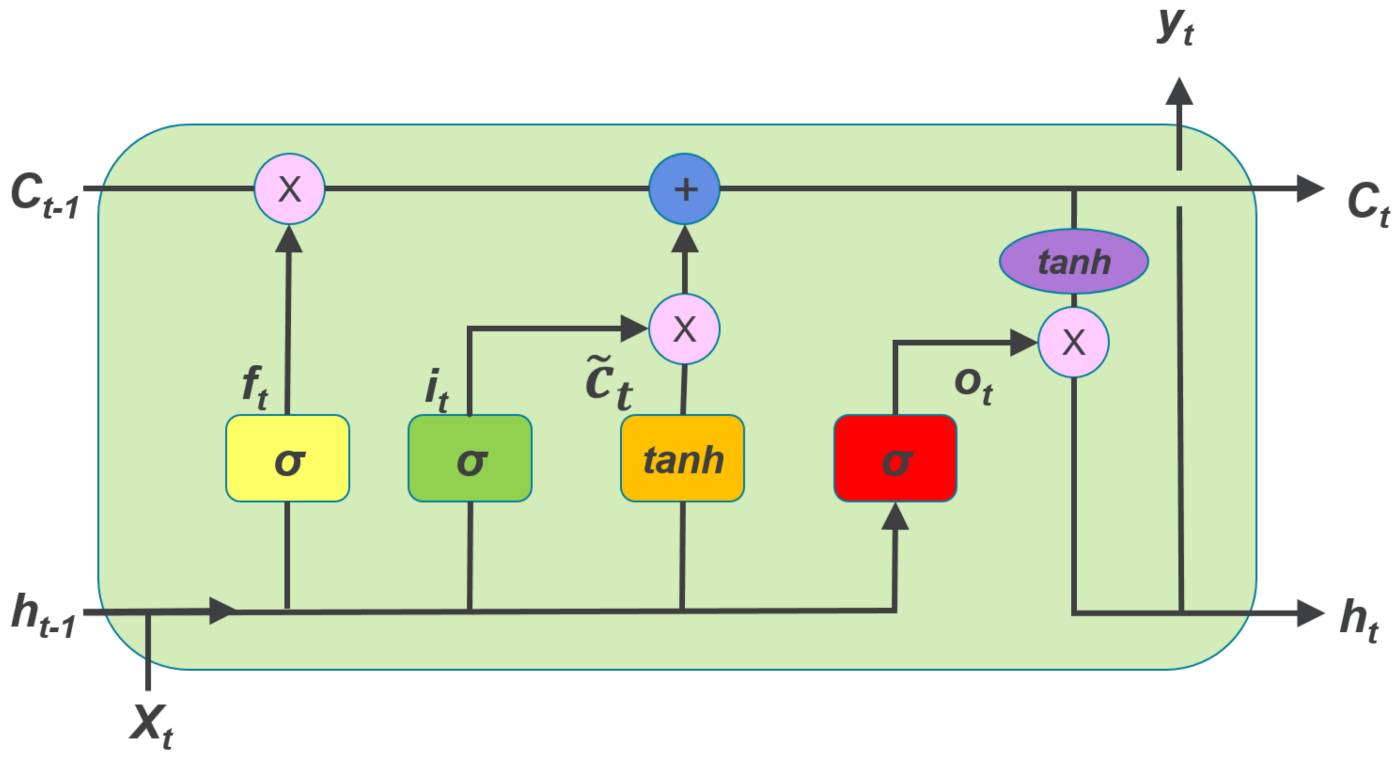

## Building our Model
We will take a series of steps to build our model
### 1) Rescaling the Data
For the model to train efficiently we need the features to have values close to each other. This is why we will use MinMaxScaler to rescale the data.
range of values is between 0 and 1

In [35]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array

num_scaling_feat = 10
num_time_steps = 10


mms = MinMaxScaler()
mms_sales = MinMaxScaler()

mms.fit(np.asarray(df2)[:,1:num_scaling_feat])
mms_sales.fit(np.asarray(df2)[:,0].reshape(-1, 1))


features, labels, test_features, test_labels = [], [], [], []
dept_stores = df2.Store_Dept_code.unique()
feat_dict, labels_dict, test_feat_dict, test_labels_dict = {}, {}, {} , {}

for val in dept_stores:    
    temp = df2.query("Store_Dept_code == @val")
    if (temp.shape[0] != 143):
        continue
    
    temp = np.asarray(temp)


    train = temp[:int(0.8*(temp.shape[0]))]
    test = temp[int(0.8*(temp.shape[0])):]

    train[:,1:num_scaling_feat] = mms.transform(train[:,1:num_scaling_feat])
    test[:,1:num_scaling_feat] = mms.transform(test[:,1:num_scaling_feat])

    sales_sc = mms_sales.transform(train[:,0].reshape(-1, 1))
    sales_test_sc = mms_sales.transform(test[:,0].reshape(-1, 1))

    train[:,0] = sales_sc.reshape(-1)
    test[:,0] = sales_test_sc.reshape(-1)
    
    train_val = timeseries_dataset_from_array(train.astype(np.float32), sales_sc[num_time_steps:].astype(np.float32) , num_time_steps , sequence_stride = 1)
    test_val = timeseries_dataset_from_array(test.astype(np.float32), sales_test_sc[num_time_steps:].astype(np.float32) , num_time_steps , sequence_stride = 1)

    for x, y  in train_val:
        feat_dict[old_names[val]] = x
        labels_dict[old_names[val]] = y
        features.append(x)
        labels.append(y)
        
    for x, y  in test_val:
        test_feat_dict[old_names[val]] = x
        test_labels_dict[old_names[val]] = y
        test_features.append(x)
        test_labels.append(y)


In [36]:
arr_shape = np.asarray(features).shape
print("So our training Data structure has the following information")
print(f"Number of unique time series: {arr_shape[0]}")
print(f"Number of Data points per each time series: {arr_shape[1]}")
print(f"Number of time stamps in each data point: {arr_shape[2]} ")
print(f"Number of Features of each time stamp: {arr_shape[3]} ")

So our training Data structure has the following information
Number of unique time series: 2628
Number of Data points per each time series: 104
Number of time stamps in each data point: 10 
Number of Features of each time stamp: 13 


In [37]:
labels = np.asarray(labels)
labels = tf.reshape(labels, [-1, labels.shape[2]])

features = np.asarray(features)
features = tf.reshape(features, [-1, features.shape[2], features.shape[3]])

test_features  = tf.convert_to_tensor(test_features)
test_features = tf.reshape(test_features, [-1, test_features.shape[2], test_features.shape[3]])

test_labels = tf.convert_to_tensor(test_labels)
test_labels = tf.reshape(test_labels, [-1, test_labels.shape[2]])

print(features.shape)
print(labels.shape)

print(test_features.shape)
print(test_labels.shape)


(273312, 10, 13)
(273312, 1)
(49932, 10, 13)
(49932, 1)


### Base Model
We will start by building a very simple base model

In [38]:
base_model = tf.keras.models.Sequential()
# Th input to an LSTM bas_model is (time_steps, features)
base_model.add(tf.keras.layers.InputLayer(input_shape=(num_time_steps, features.shape[2])))
# Westart with a simple LSTM layer with 32 layer and evaludate its performance
base_model.add(tf.keras.layers.LSTM(32,activation= 'tanh', recurrent_dropout=0.2, dropout = 0.2))
# On dense layer because this is a univariate time series
base_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
base_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss= tf.keras.losses.mean_absolute_percentage_error,
    metrics=['mae', 'mse']
)

# We will only train on the first time series to check how the model performs and after we
# finalize the model we will train on all the time series
len1 = len(labels_dict['1-1'])
len2 = len(test_labels_dict['1-1'])
base_history = base_model.fit(features[:len1,:,:], labels_dict['1-1'], batch_size = 32, epochs = 300, verbose = 0, validation_data = (test_features[:len2,:,:], test_labels_dict['1-1']))

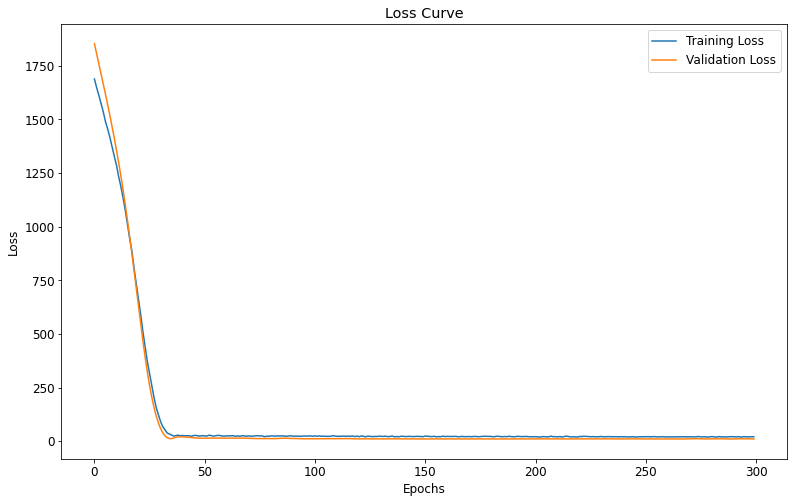

In [39]:
plotLoss(base_history, True)

In [40]:
eval_model(base_model, test_features[:len2,:,:], test_labels_dict['1-1'])

1/1 [==============================] - 0s 31ms/step - loss: 10.7109 - mae: 0.0032 - mse: 2.3331e-05
Loss: 10.710876 
Mean Absolute Error: 0.003219
Mean Squared Error: 0.000023


In [41]:
base_model.save ('base_model.h5')

In [42]:
def showPlot(id, model, randomState = False):
    if randomState:
        store_id = random.randint(0, len(unique_stores) - 1)
        dept_id = random.randint(0, len(unique_depts) - 1)
        id = str(unique_stores[store_id]) + '-' + str(unique_depts[dept_id])
        
    deptStoreId = np.where(old_names == id)[0]
    data = df.query("Store_Dept_code == @id")
    
    if deptStoreId.size != 0 and len(data) == 143:
        plt.plot(data.index, data.Weekly_Sales, 'g--')
        preds = model.predict(np.asarray(feat_dict[id]))
        len1 = preds.shape[0]
        plt.plot(data.iloc[num_time_steps:num_time_steps+len1].index, mms_sales.inverse_transform(preds), "r-")
        preds = model.predict(np.asarray(test_feat_dict[id]))
        len2 = preds.shape[0]
        plt.plot(data.iloc[-len2:].index, mms_sales.inverse_transform(preds), "b-")
        plt.xticks(rotation=45, ha='right')
        plt.legend(["Orignal", "Train", "Test"], loc='best')
        plt.ylabel("Weekly Sales")
        plt.xlabel("Date")
        plt.title(id)
    else:
        if randomState:
            showPlot(id, model, randomState)
        else: 
            print("Store not found")

1/1 [==============================] - 0s 20ms/step


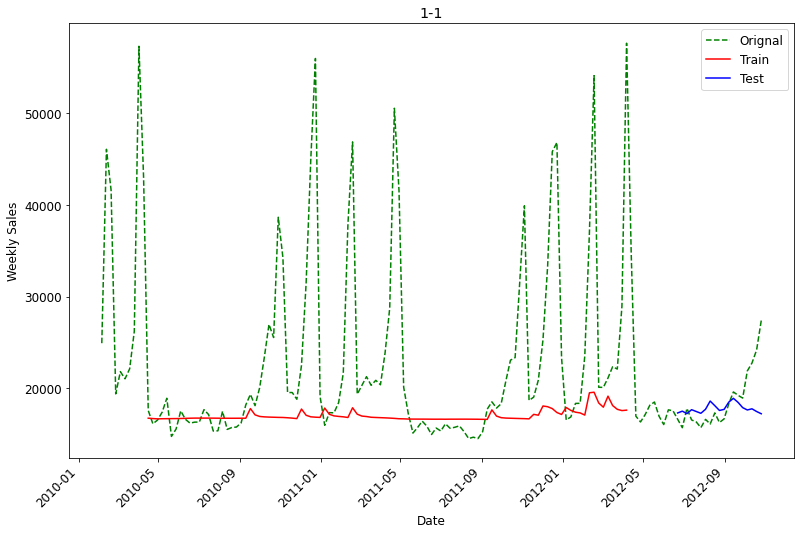

In [43]:
showPlot('1-1', base_model)

## Stacked Model
Next we try to add 2 layers of LSTM cells as well as adding some dense layers

In [44]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.InputLayer(input_shape=(num_time_steps, features.shape[2])))
stacked_model.add(tf.keras.layers.LSTM(128,activation= 'tanh', recurrent_dropout=0, return_sequences=True))
stacked_model.add(tf.keras.layers.LSTM(64,activation= 'tanh', recurrent_dropout=0, return_sequences=True))
stacked_model.add(tf.keras.layers.LSTM(32,activation= 'tanh', recurrent_dropout=0))
stacked_model.add(tf.keras.layers.Dense(512, activation= 'tanh'))
stacked_model.add(tf.keras.layers.Dropout(0.1))
stacked_model.add(tf.keras.layers.Dense(32, activation= 'tanh'))
stacked_model.add(tf.keras.layers.Dropout(0.1))
stacked_model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))

In [45]:
stacked_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.mean_absolute_percentage_error,
    metrics=['mae', 'mse']
)

len1 = len(labels_dict['1-1'])
len2 = len(test_labels_dict['1-1'])
stacked_history = stacked_model.fit(features[:len1,:,:], labels_dict['1-1'], batch_size = 32, epochs = 200, verbose = 0, validation_data = (test_features[:len2,:,:], test_labels_dict['1-1']))

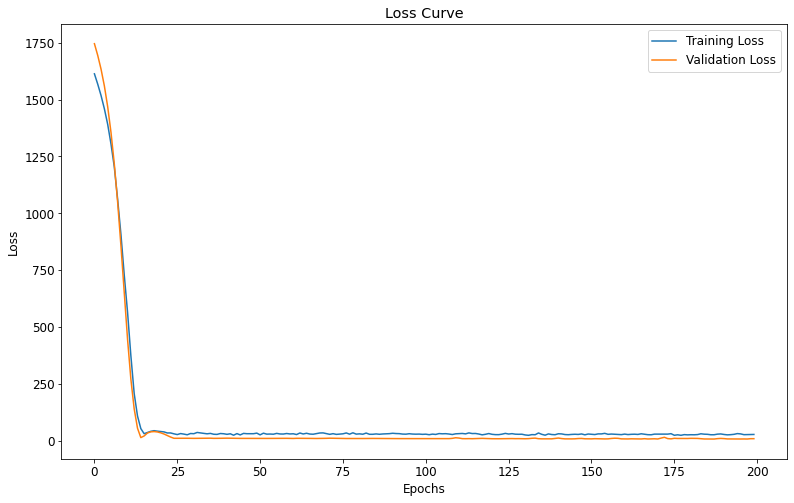

In [46]:
plotLoss(stacked_history, True)

1/1 [==============================] - 0s 20ms/step


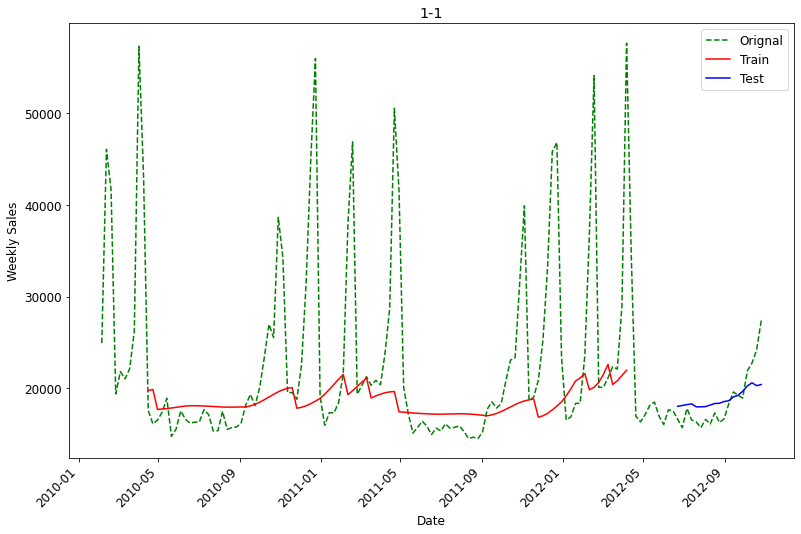

In [47]:
showPlot('1-1', stacked_model)

In [48]:
eval_model(stacked_model, test_features[:len2,:,:], test_labels_dict['1-1'])

1/1 [==============================] - 0s 26ms/step - loss: 9.4502 - mae: 0.0026 - mse: 1.1619e-05
Loss: 9.450244 
Mean Absolute Error: 0.002631
Mean Squared Error: 0.000012


In [79]:
stacked_model.save('stacked_model.h5')

### Final Model
Now that we have decided the layers for our model. We will add dropout to it and train it on the entire dataset.

In [ ]:
final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.InputLayer(input_shape=(num_time_steps, features.shape[2])))
final_model.add(tf.keras.layers.LSTM(128,activation= 'tanh', recurrent_dropout=0, return_sequences=True))
final_model.add(tf.keras.layers.LSTM(64,activation= 'tanh', recurrent_dropout=0, return_sequences=True))
final_model.add(tf.keras.layers.LSTM(32,activation= 'tanh', recurrent_dropout=0))
final_model.add(tf.keras.layers.Dense(512, activation= 'tanh'))
final_model.add(tf.keras.layers.Dropout(0.1))
final_model.add(tf.keras.layers.Dense(32, activation= 'tanh'))
final_model.add(tf.keras.layers.Dropout(0.1))
final_model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))



In [ ]:
final_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.mean_absolute_percentage_error,
    metrics=['mae', 'mse']
)

final_history = final_model.fit(features, labels, batch_size = 32, epochs = 50, verbose = 1, validation_data = (test_features, test_labels))

In [ ]:
plotLoss(final_history, True)

In [247]:
eval_model(final_model, test_features, test_labels)

1561/1561 [==============================] - 47s 30ms/step - loss: 14.5311 - mae: 0.0021 - mse: 1.9969e-05
Loss: 14.531076 
Mean Absolute Error: 0.002135
Mean Squared Error: 0.000020


In [65]:
final_model = tf.keras.models.load_model('final_model2.h5')

1/1 [==============================] - 0s 23ms/step


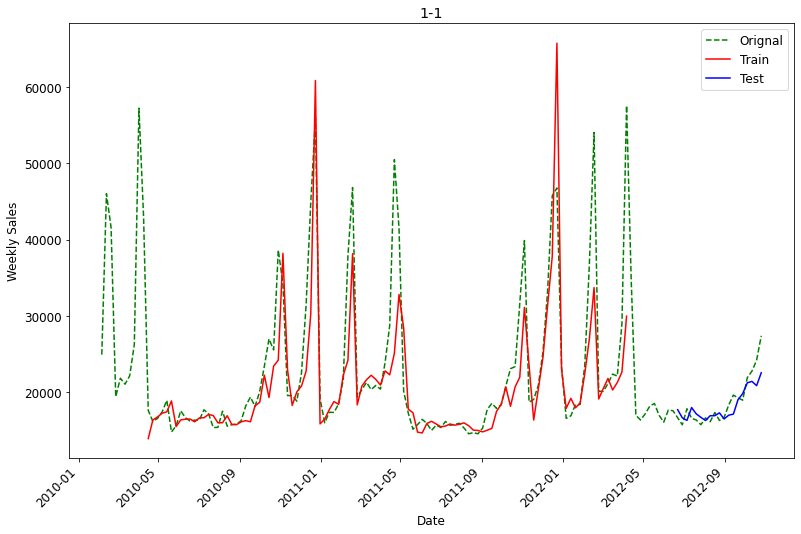

In [89]:
showPlot('1-1', final_model)

In [230]:
final_model.save('./final_model2.h5')

1/1 [==============================] - 0s 28ms/step


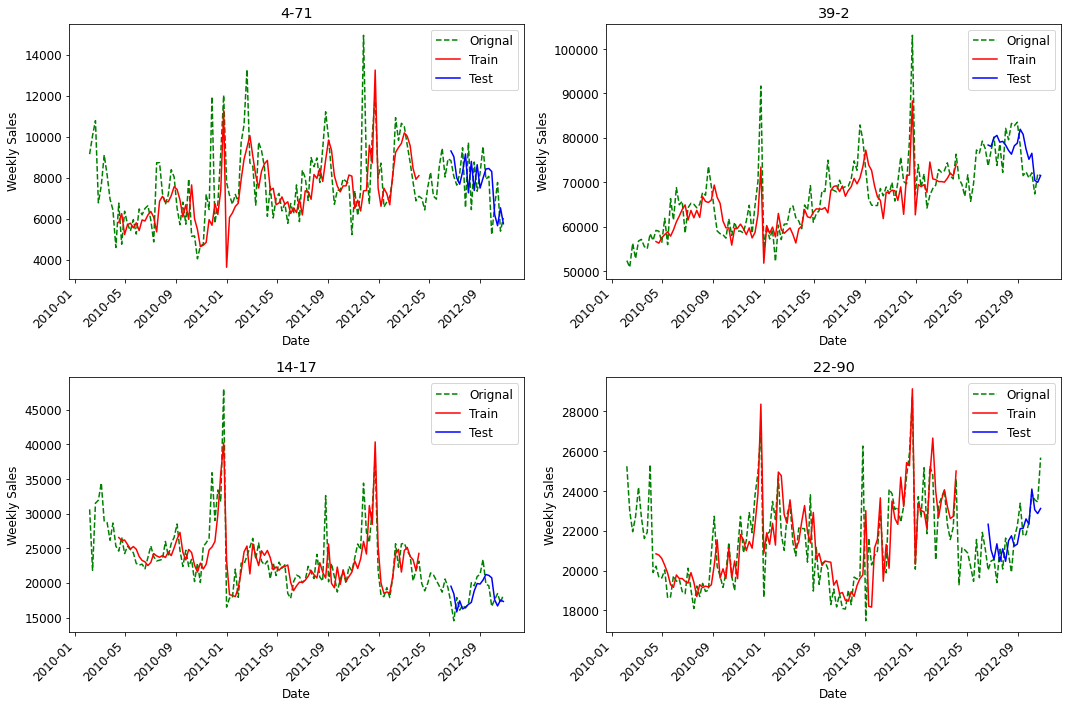

In [121]:
plt.figure(figsize=(15,10))


for i in range(4):
    plt.subplot(2,2,i+1)
    showPlot(id, final_model, True)
    
plt.tight_layout()
plt.show()

In [49]:
final_model = tf.keras.models.load_model('final_model2.h5')